In [1]:
# Make sure that you have all these libaries available to run the code successfully
#from pandas_datareader import data
#print("Importing...")
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dense, Dropout 
import time
import pickle
import requests
import json
from pandas.io.json import json_normalize
import pprint
import pandas as pd

Using TensorFlow backend.


In [2]:
def save_obj(obj, name ):
    with open('bin/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('bin/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
import numpy as np
import pandas as pd

def createDataframe(inFile, skip, dateField,priceField,separator):
    targetFile = open('datafile.csv','w') 
    file = open(inFile, 'r') 
    i=0
    for line in file: 
        i+=1
        if i>skip:
            targetFile.write(line)
    targetFile.close() 
    # Read in price field as string, and convert it later
    df = pd.read_csv('datafile.csv', sep=separator, converters={priceField: str})
    df = df.sort_values('Date', ascending=True).dropna()
    
    prices = df[[dateField,priceField]]
    # Replacing commas before typecasting 
    df[priceField].replace(',','.',inplace=True)
    # Typecasting
    df[priceField] = df[priceField].astype(float)
    # Renaming collumns
    df.rename(columns={dateField: 'Date', priceField:'Close'}, inplace=True)
    return df

#df = createDataframe('NOVO-B.CO.csv', 0,'Date','Close',',')

In [4]:

def createWindowedDataset(df, window_size, column='Close'):
    #from pandas import ordered_merge
    # Scale the data to be between 0 and 1
    # When scaling remember! You normalize both test and train data with respect to training data
    # Because you are not supposed to have access to test data
    print('Shape '+str(df.shape))
    # scale values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled=scaler.fit_transform(df[[column]])
    series=pd.DataFrame(scaled)
    
    # Creating windowed dataset
    #print('Shape '+str(series.shape))
    series_s = series.copy()
    for i in range(window_size):
        prev = series_s.shift(-(i+1))
        prev.name = str(i)
        series = pd.concat([series, prev],axis=1)
    series.dropna(axis=0, inplace=True)
    newDF = series
    newDF.dropna(axis=0, inplace=True)
    return newDF, scaler
#createWindowedDataset(df,25)


In [5]:
def getTrainNumberOfRows(fraction, series):
    nrow = round(fraction*series.shape[0])
    return nrow
#nrow = getTestNumberOfRows(0.8,ds)
#nrow

In [6]:
def buildModel(window_size):
    model = Sequential()
    #model.add(LSTM(input_shape=(window_size,1), output_dim=window_size, return_sequences = True))
    model.add(LSTM(return_sequences=True, input_shape=(window_size, 1), units=50))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("relu"))
    model.compile(loss="mse",optimizer="adam")
    model.summary
    return model

In [7]:
def trainModel(nrow, model, train_data_predictors, train_data_target, test_data_predictors, test_data_target):   
    start = time.time()
    model.fit(train_data_predictors,train_data_target,batch_size=512,epochs=20,validation_split=0.1, verbose=0)
    print("> Compilation Time : ", time.time() - start)
    return model
#trainedModel = trainModel(nrow, model, ds)




In [8]:

def downloadSymbolHistoryTemp(symbol, maxDate='2999-12-31', download=True, function='TIME_SERIES_DAILY'):
    from datetime import datetime
    # Downloads historik data for symbol.
    # Filters rows newer than maxDate, so that historic data can be simmulated
    # and training the model as of any given historic date can be performed
    errorCode=0
    #maxDate=datetime.strptime(maxDate, '%Y-%m-%d').date
    if not download:
        myDf=load_obj(symbol)
        print("Note: Loaded persisted time series data")
        return myDf[myDf.index<=datetime.strptime(maxDate, '%Y-%m-%d').date()],0

    url = "https://www.alphavantage.co/query"
    api_key=os.environ["alphavantagetoken"]
    datatype = "json"
    outputsize = "full"

    if function=='TIME_SERIES_DAILY':
        searchString='Time Series (Daily)'
        data = { "function"   : function, 
             "symbol"     : symbol, 
             "apikey"     : api_key ,
             "datatype"   : datatype,
             "outputsize" : 'full'} 
    else:
        searchString='Time Series (60min)'
        data = { "function"   : function, 
             "symbol"     : symbol, 
             "apikey"     : api_key ,
             "datatype"   : datatype,
            "interval":'60min',
             "outputsize" : 'full'} 
    print("For "+symbol)
    print("Note: Downloading time series data from "+url)
    page = requests.get(url, params = data)
    response_data = page.json()
    try:
        timeSeriesJson = (response_data[searchString])
    except:
        print("Error - retrying every 120 secs...")
        for i in range(1,6):
            try:
                time.sleep(120)
                print("Retrying...")
                page = requests.get(url, params = data)
                response_data = page.json()
                timeSeriesJson = (response_data[searchString])
                print("Success")
                break
            except:
                errorCode+=1
                print("Error - retrying every 120 secs...")
                pass
            if i == 5:
                print("################################################")
                print("Warning: Did not succeed after 5 retrys, exiting")
                print("################################################")
                errorCode=6
                return None, errorCode

    myDict = {}
    for key, value in timeSeriesJson.items():
        myDict[key] = value.get('4. close')
    myDf = pd.DataFrame.from_dict(myDict, orient='index')    
    myDf.columns = ['Close']
    myDf.index.name = 'Date'
    # For intraday queries, keep only last entry pr. day
    if function=='TIME_SERIES_INTRADAY':
        myDf=myDf.groupby(myDf.index.str[:10]).head(1)
        #print(myDf.dtypes)
    myDf.index = pd.to_datetime(myDf.index).date
        #print(myDf)
        #myDf['Date1']=myDf.index.dt.date
    myDf.sort_index(inplace=True, ascending=True)
    #print(myDf)
    lst = []
    prevLst = []
    prevClose = 1
    for index, row in myDf.iterrows():
        if row['Close'] == 0:
            Close = prevClose
        else:
            Close = row['Close']
        if float(row['Close']) != 0:
            prevClose = Close
        lst.append(Close)
        prevLst.append(prevClose)
        
    myDf['Close'] = pd.Series(prevLst).values
    df = pd.DataFrame()
    counter=0
    rel = []
    for index, row in myDf.iterrows():
        if counter==0:
            prev=float(row['Close'])
        r=(float(row['Close'])-prev)/prev
        rel.append(r)
        counter+=1
        prev=float(row['Close'])
    se = pd.Series(rel)
    myDf['Relative'] = se.values
    myDf['prevClose'] = prevLst
    # Compensate for holes in history data, by merging in previously saved data
    # and keeping pricedata that are in historiv downloads but not in current,
    # thereby building up local history data.
    try:
        myDf_=load_obj(symbol)
        myDf_.index.name = 'Date'
        myDf.index.name = 'Date'
        #print(myDf[:1])
        #print(myDf_[:1])
        #print('a')
        jn=pd.merge(myDf, myDf_, left_on='Date',right_on='Date' ,how='outer')
        #print('b')
        #jn['Close']=np.where(jn['Close_x']!=np.nan,jn['Close_x'],jn['Close_y'])
        jn['Close']=jn['Close_x'].fillna(jn['Close_y'])
        jn['Relative']=jn['Relative_x'].fillna(jn['Relative_y'])
        jn['prevClose']=jn['prevClose_x'].fillna(jn['prevClose_y'])
        #jn['Close']=np.where(jn['Close_x']!=np.nan,jn['Close_y'],jn['Close_x'])
        #jn['Relative']=np.where(jn['Relative_x']!=np.nan,jn['Relative_x'],jn['Relative_y'])
        #jn['prevClose']=np.where(jn['prevClose_x']!=np.nan,jn['prevClose_x'],jn['prevClose_y'])
        save_obj(jn[['Close','Relative','prevClose']], symbol)
    except Exception as e:
        print('Error')
        print(e)
        save_obj(myDf,symbol)
        return myDf[myDf.index<=datetime.strptime(maxDate, '%Y-%m-%d').date()], errorCode
    #save_obj(myDf,symbol)
    rtDataframe=jn[['Close','Relative','prevClose']]
    r=rtDataframe.sort_index(ascending=True)
    return r, errorCode
    #return myDf_[myDf_.index<=datetime.strptime(maxDate, '%Y-%m-%d').date()], errorCode
#a,b=downloadSymbolHistory('SXRT.DE', '2099-12-31', True, 'TIME_SERIES_INTRADAY')
def downloadSymbolHistory(symbol, maxDate, download):
    a,b=downloadSymbolHistoryTemp(symbol, maxDate, download, 'TIME_SERIES_INTRADAY')
    a,b=downloadSymbolHistoryTemp(symbol, maxDate, download, 'TIME_SERIES_DAILY')
    return a,b
a,b=downloadSymbolHistory('SXRT.DE', '2099-12-31', True)
#load_obj('NLFSK.CPH').tail(2)#.query('Close_x != Close_y')
a

For SXRT.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For SXRT.DE
Note: Downloading time series data from https://www.alphavantage.co/query


,Close,Relative,prevClose
Date,,,
2010-03-11,66.7300,0.000000,66.7300
2010-03-12,66.8000,0.001049,66.8000
2010-03-15,66.1700,-0.009431,66.1700
2010-03-16,67.0200,0.012846,67.0200
2010-03-17,67.5300,0.007610,67.5300
2010-03-18,67.1700,-0.005331,67.1700
2010-03-19,67.6600,0.007295,67.6600
2010-03-22,67.6600,0.000000,67.6600
2010-03-23,67.6600,0.000000,67.6600


In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def prepareAndTrain(symbol,df, maxDate='2999-12-31', window_size=50, column='Close',plot=True):
    alphaVantageAipKey=os.environ["alphavantagetoken"]
    #window_size=50
    #trainNRows = getTrainNumberOfRows(0.8,ds)
    #symbols = ['GOOGL']
    
    
    # Create the windowd dataframe
    series, scaler = createWindowedDataset(df,window_size, column)
    trainNrows = getTrainNumberOfRows(0.97,series)
    # Define the model
    model=buildModel(window_size)    
    # Create the train and test-dataset
    # Use the first
    print('trainNrows: '+str(trainNrows))
    #print('DS shape '+str(df.shape))
    train = series.iloc[:trainNrows, :]
    test = series.iloc[trainNrows:,:]
    # Now, shuffle the train-set
    from sklearn.utils import shuffle
    train = shuffle(train)
    # train_X is all rows, all columns minus last, which is the target variable
    train_X = train.iloc[:,:-1].values
    # train_y is all rows, last column only, which is the target variable
    train_y = train.iloc[:,-1].values
    test_X = test.iloc[:,:-1].values
    test_y = test.iloc[:,-1].values
    print('**')
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
    trainedModel = trainModel(trainNrows, model, train_X, train_y, test_X, test_y)
        
    from matplotlib import pyplot
    ac=np.asarray(test_y).reshape(-1,1)
    actuals = scaler.inverse_transform(ac)
    pd = trainedModel.predict(test_X)
    predicts=scaler.inverse_transform(pd)
    mape = mean_absolute_percentage_error(actuals,predicts)
    if plot==True:
        pyplot.plot(actuals)
        pyplot.plot(predicts)
        pyplot.show()
        import pandas as pd
        d = pd.DataFrame({'actuals':actuals.flatten('F'), 'predicts':predicts.flatten('F')})
        print("Mean Absolute Error: "+str(mean_absolute_error(actuals,predicts)))
        print("Mean Squared Error: "+str(mean_squared_error(actuals,predicts)))
        print("Mean Absolute Percentage Error: "+str(mape))
    #return df, trainedModel, scaler, mape
    return trainedModel, scaler, mape

#data, tm, sc = prepareAndTrain('GOOGL')


In [11]:
# Defining function to predict n future values.
# Returns list of n predictions as numpy array, and last prediction as float
#input = test_X[0]
nDays = 5
def predictNdays(nDays, trainedModel, scaler, inputSequence):
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [inputSequence]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(nDays):
        #print(i)
        preds_one_step = trainedModel.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    lastNDaysPredictions = moving_test_window[0][len(moving_test_window)-(nDays+2):]
    nthDayPrediction = lastNDaysPredictions[0].tolist()[0]
    lastDayPrediction = scaler.inverse_transform(nthDayPrediction)[0][0]
    return scaler.inverse_transform(lastNDaysPredictions), lastDayPrediction

#predictNdays(5, trainedModel, scaler, test_X[0])

Building the code that will run continously.
We´ll skip the test-part, because we´re now only predicting

In [12]:

def predict(symbol, window_size, predictDays, data, tm, sc, maxDate='2999-12-31', column='Close'):
    #data, tm, sc, mape = prepareAndTrain(symbol, maxDate, window_size,column, True)
    se,sc = createWindowedDataset(data,window_size, column)
    latestSequence=se[len(se)-1:].values
    latestSequence = latestSequence.reshape(latestSequence.shape[1],latestSequence.shape[0])[len(latestSequence):]
    nDays, nThDay = predictNdays(predictDays, tm, sc, latestSequence)
    sc.inverse_transform(latestSequence)
    nDays, nThDay
    return nDays, mape

In [13]:
# Gets the closing price for the following trading day
def getNextClose(symbol, date='2999-12-31', column='Close'):
    if date=='2999-12-31':
        print("Error: No date supplied - cannot get next closingprice")
    data = downloadSymbolHistory(symbol)
    data.insert(0, 'row_num', range(0,len(data)))  # here we insert the row count
    y = data.loc[date]['row_num']
    nextClose=data.loc[data['row_num'] == y+1]
    return pd.to_numeric(nextClose[column], errors='coerce').tolist()[0]
#getNextClose('NYSE:AXP', date='2017-12-12')
    

In [14]:
# Returns a list of valid tradingdays for the supplied symbol
def getTradingDays(symbol):
    data,errorCode = downloadSymbolHistory(symbol,'2999-12-31', False)
    return data.index.tolist()
getTradingDays('NLFSK.CPH')[10]

Note: Loaded persisted time series data
Note: Loaded persisted time series data


datetime.date(2017, 10, 26)

In [15]:
#getTradingDays('DWDP')
#getNextClose('DWDP', '2018-07-02')
#downloadSymbolHistory('DWDP')

In [16]:
#nDays, nThDay = predictNdays(nDays, tm, sc)
import time
#############################
# Setup                     #
#############################
sleepSecs = 600
results = {}
funds=10000
trainOnce=True
symbols = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DWDP','XOM','GS','HD','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['BA']
column='Close'
window_size=50
symbolGains = {}

#############################
def backtestLSTM():
    for symbol in symbols:
        downloadSymbolHistory(symbol,'2999-12-31','download')
        days = [days for days in getTradingDays(symbol) if days >= '2018-07-01' and days < '2018-08-01']
        print("*****************************")
        print("Simmulating "+str(len(days))+" days for "+symbol)
        #tradingDays=getTradingDays(symbol)
        dayNumber=0
        for day in days:
            startFunds=funds
            dayNumber+=1
            print("")
            print (time.strftime("%H:%M:%S"))
            print("***")
            print("Simmulating "+symbol+" at date: "+day)
            #break
            data=downloadSymbolHistory(symbol, day)
            if dayNumber==1:
                print("Training...")
                tm, sc, mape = prepareAndTrain(symbol, data, day, window_size,column, True)
            else:
                if trainOnce==False:
                    print("Training...")
                    tm, sc, mape = prepareAndTrain(symbol,data, day, window_size,column, True)
            nDays, mape = predict(symbol,window_size,5, data, tm, sc, day, column) #Close vs Relative
            latestClose=nDays[0][0]
            nextClose=nDays[1][0]
            fourDaysClose=nDays[4][0]
            actualNextClose=getNextClose(symbol, day, column)
            gainPct = round((nextClose-latestClose)/latestClose*100,2)    
            fourDaysGainPct = round((fourDaysClose-latestClose)/latestClose*100,2)        
            print("***")
            print(symbol+":")
            print("MAPE             :"+str(mape))        
            if column == 'Close':
                print("Latest close     : "+str(latestClose))
                print("Next close       : "+str(nextClose)+" ("+str(gainPct)+"%)")
                print("4 Days close     : "+str(fourDaysClose)+" ("+str(fourDaysGainPct)+"%)")
                print("Actual next close: "+str(actualNextClose))
                if gainPct>0.50:
                    print("Bying and selling - funds before: "+str(round(funds,2)))
                    funds=(funds/latestClose*actualNextClose)-29
                    print("Bought and sold - funds now: "+str(round(funds,4)))
            if column == 'Relative':
                print("Latest close     : "+str(round(latestClose*100,4))+'%')
                print("Next close       : "+str(round(nextClose*100,4))+"%")
                print("4 Days close     : "+str(round(fourDaysClose*100,4))+"%")
                print("Actual next close: "+str(round(actualNextClose*100,4))+"%")
                if nextClose>0.005:
                    print("Bying and selling - funds before: "+str(round(funds,2)))
                    funds=(funds*(actualNextClose+1))-29
                    print("Bought and sold - funds now: "+str(round(funds,2)))
            results[symbol]=[nDays,[mape]]
        print("Funds total: "+str(round(funds,2)))
        symbolGains[symbol]=str(round((funds-startFunds)/funds*100,4))+'%'
        print(symbolGains)
    
        #print("Sleeping before next symbol")
        #time.sleep(sleepSecs)
    
    
    

In [17]:
def doStuff():
    for key, value in results.items():
        nDays=value[0]
        mape = value[1]
        #print(mape[0])
        print(key+":")
        print("Mean Percentage Absolute Error: "+str(round(mape[0],2))+"%")
        print("Latest close                  : "+str(nDays[0][0]))
        print("Next close                    : "+str(nDays[1][0])+" ("+str(round((nDays[1][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
        print("Close in "+str(len(nDays)-1)+" days               : "+str(nDays[5][0])+" ("+str(round((nDays[5][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
        print('***')

## Doing classic SMA (Simple Moving Average) (shot/long) and looking for "golden cross" and "death cross"

In [18]:
import smtplib
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate


def sendMail(send_from, send_to, subject, text, files, server="smtp.gmail.com:587"):
    #assert isinstance(send_to, list)

    msg = MIMEMultipart()
    msg['From'] = send_from
    #msg['To'] = COMMASPACE.join(send_to)
    msg['To'] = send_to
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fil:
            part = MIMEApplication(
                fil.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)


    smtp = smtplib.SMTP(server)
    smtp.starttls()
    smtp.login(send_from, os.environ["googletoken"])
    
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()
#sendMail('pedersbak@gmail.com','pedersbak@gmail.com', 'My subject', 'My message', ['output.pdf'])



In [ ]:

import math
import datetime
plot=True
verbose=False
funds=10000
portfolio={}
from fpdf import FPDF

def buy(symbol, price, message=None):
    global funds
    global portfolio
    global verbose
    numberOfShares = math.floor(funds/price)
    rest = funds-numberOfShares*price
    funds=rest
    if portfolio.get(symbol,'NA')=='NA':
        if verbose==True:
            print("************")
            if message!=None:
                print(message)
            print("Buying "+str(numberOfShares)+" "+symbol+" at "+str(price)+" totalling "+str(numberOfShares*price))
            print("Funds now: "+str(funds))
        portfolio[symbol]=numberOfShares

def sell(symbol, price, message=None):
    global funds
    global portfolio
    global verbose
    if portfolio.get(symbol,'NA')!='NA':
        funds=funds+portfolio.get(symbol)*price
        numberOfShares=portfolio.get(symbol)
        if verbose==True:
            print("************")
            if message!=None:
                print(message)
            print("Selling "+str(numberOfShares)+" "+symbol+" at "+str(price)+" totalling "+str(numberOfShares*price))
            print("Funds now: "+str(funds))
        portfolio.pop(symbol, None)
        
def removePics():
    import os
    dir_name = "./bin/"
    test = os.listdir(dir_name)
    for item in test:
        if item.endswith(".png"):
            os.remove(os.path.join(dir_name, item))

def generatePDF(imageList, imagesPrPage=1):   
    pdf=FPDF()
    #pdf.add_page()
    p=1
    for count, image in enumerate(imageList):
        if count%imagesPrPage == 0:
            pdf.add_page()
        pdf.image(image, x=None, y=None, w=160, h=80)
    pdf.output('output.pdf',"F")

def RSI(df, column="Close", period=14):
    # wilder's RSI 
    #pd.to_numeric(s, errors='coerce')
    #d=pd.to_numeric(df[column])
    d=pd.to_numeric(df[column])
    delta = d.diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
    rsi = 100 - 100 / (1 + rUp / rDown)    
#    #return df.join(rsi.to_frame('RSI'))
    #print(type(list(rsi)))
    return list(rsi)



def runSmaAnalysis(plot, verbose, symbols, download):
    global funds
    global portfolio
    signals = {}
    imageList = []

    #symbols={'SXRT.DE':'EURO STOXX50'}
    if type(symbols) is dict:
        descriptionDict=symbols
        symbols=list(symbols.keys())
    
    short = 10
    long = 30
    stopLoss = .04
    # To supress rsi signals, they are set to impossible values
    # Nomal values are 70 and 30
    rsiUpper = 170
    rsiLower = -30
    #del result
    for symbol in symbols:
        fundsBefore=funds
        data, errorCode = downloadSymbolHistory(symbol,'2999-12-31',download)
        print("errorCode: "+str(errorCode))
        if errorCode>0:
            print("Error in data download for "+symbol)
            continue
            
        #days = [days for days in getTradingDays(symbol) if days >= '2017-07-01' and days < '2018-08-01']
        days = [days for days in getTradingDays(symbol) 
                if  days >= datetime.datetime.strptime('2017-07-01', '%Y-%m-%d').date() 
                and days <= datetime.date.today()]
        #.strftime("%Y-%m-%d")
        #data = data[data.index.isin(days)]
        print("*****************************") 
        print("Simmulating "+str(len(days))+" days for "+symbol)
        #print("Funds now: "+str(funds))
    
    
        # creating short ans long sma´s
        sma_short = data.Close.rolling(window=short).mean() 
        sma_long  = data.Close.rolling(window=long).mean() 
    
        # Creating prev-values
        prev_sma_short = sma_short.shift(1)    
        prev_sma_long = sma_long.shift(1)
        rsi = RSI(data)
        prev1_rsi = pd.Series(rsi).shift(1).tolist()
        prev2_rsi = pd.Series(rsi).shift(2).tolist()
        prev3_rsi = pd.Series(rsi).shift(3).tolist()
        prev4_rsi = pd.Series(rsi).shift(4).tolist()
        prev5_rsi = pd.Series(rsi).shift(5).tolist()
        prev6_rsi = pd.Series(rsi).shift(6).tolist()
        prev7_rsi = pd.Series(rsi).shift(7).tolist()
        prev8_rsi = pd.Series(rsi).shift(8).tolist()
        prev9_rsi = pd.Series(rsi).shift(9).tolist()
        prev10_rsi = pd.Series(rsi).shift(10).tolist()
        p=pd.to_numeric(data['Close'], errors='coerce')
        prev_close = p.shift(1)
        
        ##############################################
        # Putting together the result dataset        #
        ##############################################
        result = pd.DataFrame({'Close':pd.to_numeric(data['Close'], errors='coerce'),
                           'prev_close':prev_close,
                           'sma_short':sma_short,
                           'prev_sma_short':prev_sma_short,
                           'sma_long':sma_long,
                           'prev_sma_long':prev_sma_long,
                           'rsi':rsi,
                           'prev1_rsi':prev1_rsi,
                           'prev2_rsi':prev2_rsi,
                           'prev3_rsi':prev3_rsi,
                           'prev4_rsi':prev4_rsi,
                           'prev5_rsi':prev5_rsi,
                           'prev6_rsi':prev6_rsi,
                           'prev7_rsi':prev7_rsi,
                           'prev8_rsi':prev8_rsi,
                           'prev9_rsi':prev9_rsi,
                           'prev10_rsi':prev10_rsi}).dropna(axis=0)
        #print(days)
        result = result[result.index.isin(days)]
        days=result.index.tolist()
        daysDate = pd.Series([pd.to_datetime(date).date() for date in days])
        ####################################################
        # Run through historic tradingdays for backtesting #
        ####################################################
        #print(result)
        for day in days:
            v = result.loc[day,]
            delta=round((v.Close-v.prev_close)/v.prev_close,2)
            if delta < -stopLoss:
                sell(symbol, v.Close, "StopLoss !")
            elif (v.sma_short > v.sma_long) & (v.prev_sma_short < v.prev_sma_long):
                buy(symbol, v.Close)            
            elif (v.sma_short < v.sma_long) & (v.prev_sma_short > v.prev_sma_long):
                sell(symbol, v.Close)
        if portfolio.get(symbol) != None:
            v = result.iloc[-1]
            sell(symbol,v.Close, 'Force selling simulation')
        print("************")
        print("Total result: ")
        print(str(round((funds-fundsBefore)/fundsBefore*100))+"%")
        sigForPlot = 'No signal'
        ##############################################
        # Generating signals for the last tradingday #
        ##############################################
        #delta=round((v.Close-v.prev_close)/v.prev_close,3)
        if delta < -stopLoss:
            print("StopLoss")
            print(str(delta))
            print("Close "+str(v.Close))
            print("Prev Close "+str(v.prev_close))
            signals[symbol]='StopLoss | RSI: '+str(v.rsi)
            sigForPlot = 'StopLoss: ' +str(delta*100)+'%'
        if (v.sma_short > v.sma_long) & (v.prev_sma_short < v.prev_sma_long):
            print("SMA buy")
            signals[symbol]='SMA buy | RSI: '+str(v.rsi)
            sigForPlot = 'SMA buy | RSI: '+str(v.rsi)
        elif (v.sma_short < v.sma_long) & (v.prev_sma_short > v.prev_sma_long):
            print("SMA sell")
            signals[symbol]='SMA sell | RSI: '+str(v.rsi)
            sigForPlot = 'SMA sell | RSI: '+str(v.rsi)
        if (v.rsi < rsiLower and v.prev1_rsi > rsiLower):
            signals[symbol]=signals.get(symbol,'')+'RSI buy (oversold)'
        elif (v.rsi > rsiUpper and v.prev1_rsi < rsiUpper):
            signals[symbol]=signals.get(symbol,'')+'RSI sell (overbought)'
        ##############################################
        # Generate plots                             #
        ##############################################
        #print(str(plot))
        if plot==True:
            f=plt.figure(figsize=(10,5))
            f.suptitle(symbol+': '+descriptionDict.get(symbol), fontsize=16)
            ax = f.add_subplot(111)
            ax.set_title(str(day)+str(": Close @"+str(v.Close))+' - delta: '+str(delta*100)+'%'+' - ' +'RSI @'+str(round(v.rsi,1))+' '+sigForPlot)
            ax.plot(daysDate, result.sma_short, label="SMA short", color="red")
            ax.plot(daysDate, result.sma_long,  label="SMA long", color="blue")
            #ax.plot(daysDate, pd.to_numeric(result.Close, errors='coerce'), color="black")
            ax.plot(daysDate, result.Close, color="black")
            ax.set_ylabel('Closing price', color='black')
            ax.legend(loc='lower center')
            
            ax2 = ax.twinx()
            ax2.plot(daysDate, result.rsi, 'r-', color='grey')
            ax2.set_ylabel('Relative Strength Index (RSI)', color='grey')
            
            horizontal30 = np.array([30 for i in range(len(daysDate))])  
            ax2.plot(daysDate, horizontal30, 'r-', color='grey')
            horizontal70 = np.array([70 for i in range(len(daysDate))])  
            ax2.plot(daysDate, horizontal70, 'r-', color='grey')
            
            plt.show()
            f.savefig('./bin/'+symbol+".png")
        imageList.append('./bin/'+symbol+".png")
        ##############################################
        # Generate plots                             #
        ##############################################
        print("Done simmulating")
        print("*****************************")
    generatePDF(imageList,3)
    return signals, result

download=True
symbolsUSA = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','XOM','GS','HD','IBM','INTC',\
                  'JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA','GOOGL']
symbolsDK = ['MAERSK-A.CPH','MAERSK-B.CPH','BAVA.CPH','CARL-B.CPH','CHR.CPH','COLO-B.CPH'\
               ,'DANSKE.CPH','DSV.CPH','FLS.CPH','GEN.CPH','GN.CPH','ISS.CPH','JYSK.CPH','LUN.CPH'\
               ,'NOVO-B.CPH','NZYM-B.CPH','PNDORA.CPH','RBREW.CPH','SIM.CPH','TRYG.CPH','VWS.CPH','WDH.CPH'\
               ,'ORSTED.CPH','ALK-B.CPH','DFDS.CPH','CARL-A.CPH','GFS.CPH','JDAN.CPH','TRYG.CPH','TOP.CPH'\
            ,'SYDB.CPH','STG.CPH','SCHO.CPH','ROCK-B.CPH','ROCK-A.CPH','RILBA.CPH','OSSR.CPH','NLFSK.CPH','NKT.CPH'\
            ,'NETC.CPH','NDA-DK.CPH','LUN.CPH','KBHL.CPH','JDAN.CPH','FLS.CPH','DSV.CPH']
symbols=symbolsUSA+symbolsDK
#'ALM-B.CPH',
#symbols=['SXRT.DE']
symbols={'SXRT.DE':'Euro STOXX 50',
         'IQQ9.DE':'FTSE BRIC 50',
         'IQQC.DE':'FTSE China 50',
         'EUNN.DE':'MSCI Japan',
         'SXR1.DE':'MSCI Pacific ex-Japan',
         'EUNL.DE':'MSCI World',
         'SXR8.DE':'S&P 500','SXRU':'Dow Jones Industrial',
         'IUSR.DE':'EURO STOXX 50 ex-Finanance',
         'SXRW.DE':'FTSE 100 UK',
         'SXRY.DE':'FTSE MIB Index / Italy',
         'IBC6.DE':'MSCI Australia UCITS',
         'CEBL.DE':'MSCI Emerging Markets Asia',
         'IUSC.DE':'MSCI Emerging Markets Latin America',
         'XDDX.DE':'DAX Income'}
#signals, result = runSmaAnalysis(True, True, symbols, download)
#sendMail('pedersbak@gmail.com','pedersbak@gmail.com','Testindhold' ,'Signals for today',['output.pdf'])

In [ ]:
#result.sort_index(ascending=False)[['Close','prev_close']]

For IQQC.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For IQQC.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 368 days for IQQC.DE
************
Total result: 
-9.0%


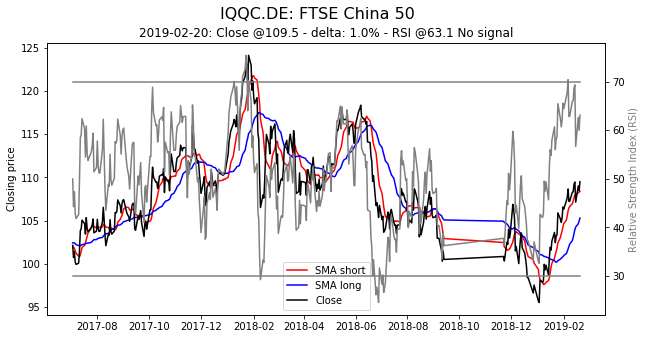

Done simmulating
*****************************
For SXRY.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For SXRY.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error - retrying every 120 secs...
Retrying...
Success
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 414 days for SXRY.DE
************
Total result: 
-11.0%


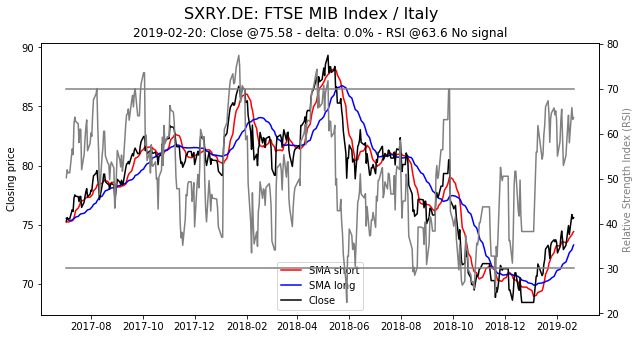

Done simmulating
*****************************
For IUSC.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For IUSC.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 367 days for IUSC.DE
************
Total result: 
15.0%


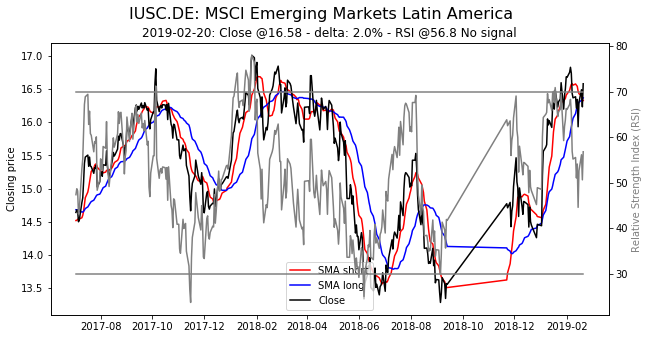

Done simmulating
*****************************
For EUNN.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For EUNN.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 368 days for EUNN.DE
************
Total result: 
6.0%


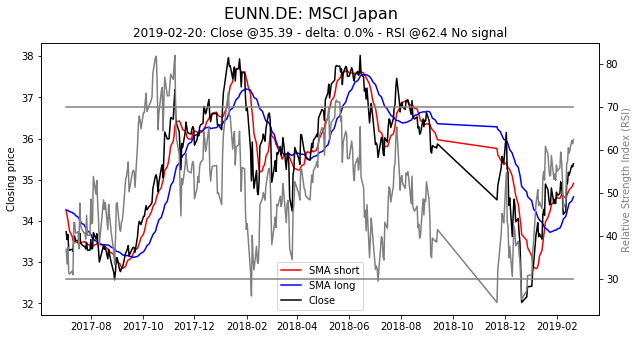

Done simmulating
*****************************
For CEBL.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error - retrying every 120 secs...
Retrying...
Success
Error
[Errno 2] No such file or directory: 'bin/CEBL.DE.pkl'
For CEBL.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for CEBL.DE
************
Total result: 
-6.0%


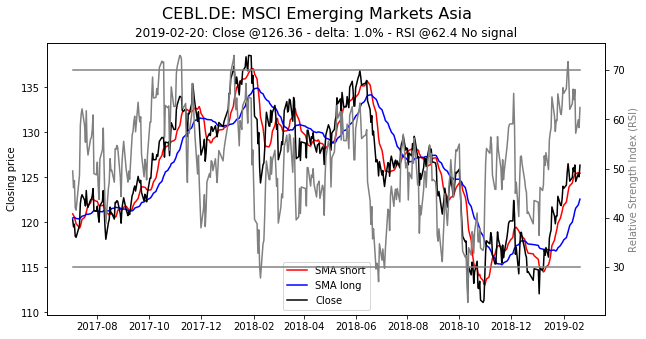

Done simmulating
*****************************
For IBC6.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For IBC6.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 366 days for IBC6.DE
************
Total result: 
4.0%


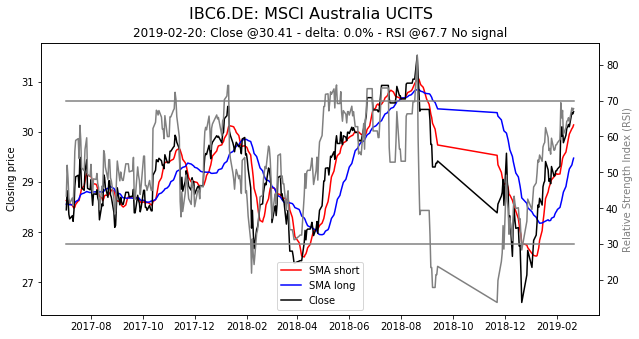

Done simmulating
*****************************
For SXRT.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For SXRT.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error - retrying every 120 secs...
Retrying...
Success
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for SXRT.DE
************
Total result: 
-11.0%


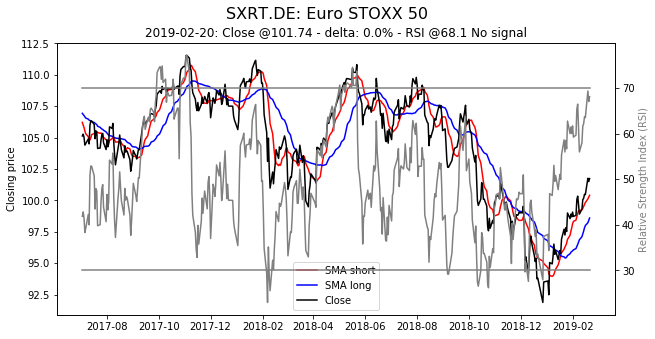

Done simmulating
*****************************
For IQQ9.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For IQQ9.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 367 days for IQQ9.DE
************
Total result: 
-3.0%


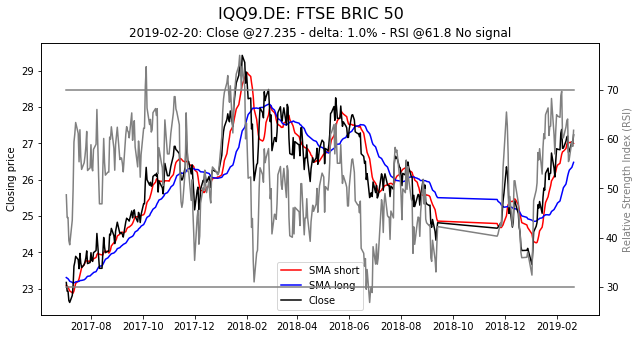

Done simmulating
*****************************
For SXRU.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error
[Errno 2] No such file or directory: 'bin/SXRU.DE.pkl'
For SXRU.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for SXRU.DE
************
Total result: 
4.0%


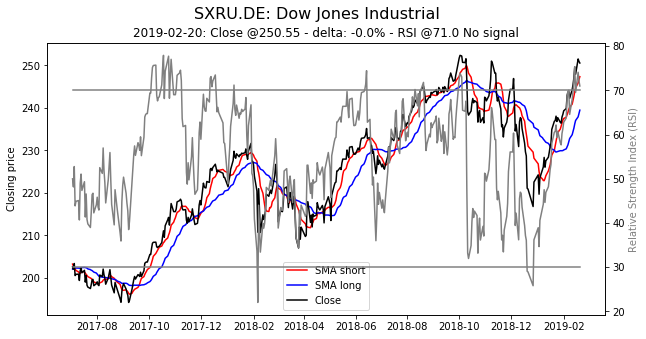

Done simmulating
*****************************
For SXRW.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For SXRW.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for SXRW.DE
************
Total result: 
4.0%


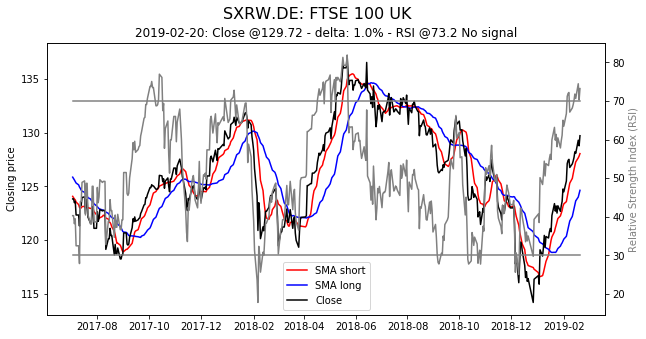

Done simmulating
*****************************
For XDDX.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error - retrying every 120 secs...
Retrying...
Success
For XDDX.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for XDDX.DE
************
Total result: 
-15.0%


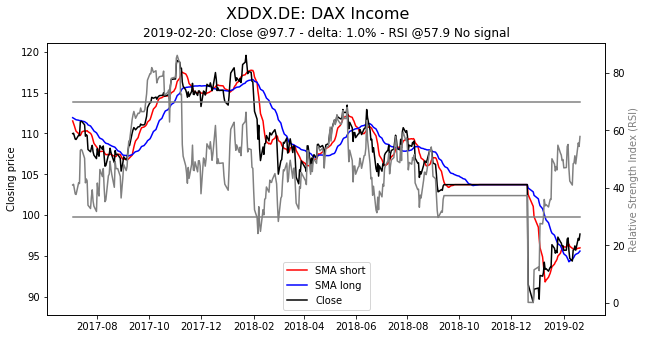

Done simmulating
*****************************
For IUSR.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For IUSR.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for IUSR.DE
************
Total result: 
-8.0%


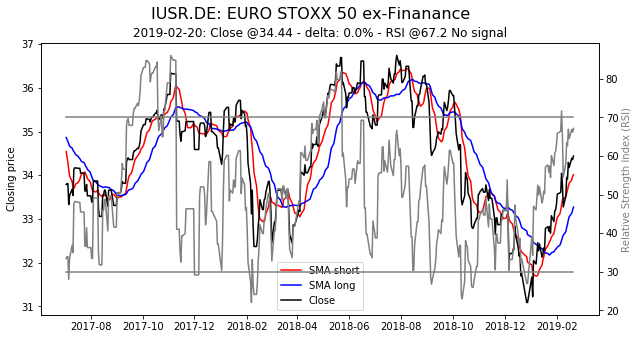

Done simmulating
*****************************
For EUNL.DE
Note: Downloading time series data from https://www.alphavantage.co/query
For EUNL.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error - retrying every 120 secs...
Retrying...
Success
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 368 days for EUNL.DE
************
Total result: 
8.0%


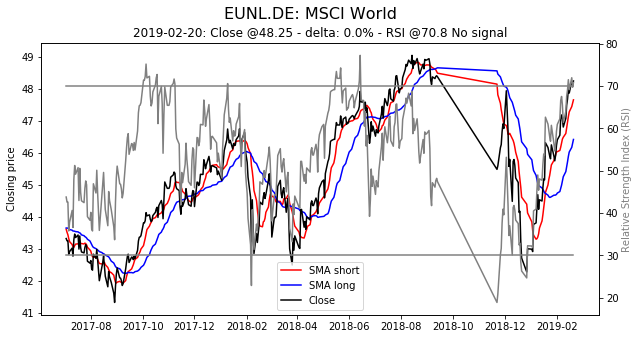

Done simmulating
*****************************
For SXR8.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error
[Errno 2] No such file or directory: 'bin/SXR8.DE.pkl'
For SXR8.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for SXR8.DE
************
Total result: 
2.0%


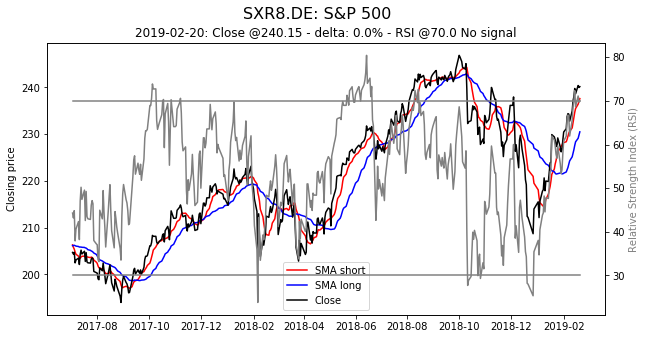

Done simmulating
*****************************
For SXR1.DE
Note: Downloading time series data from https://www.alphavantage.co/query
Error
[Errno 2] No such file or directory: 'bin/SXR1.DE.pkl'
For SXR1.DE
Note: Downloading time series data from https://www.alphavantage.co/query
errorCode: 0
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 416 days for SXR1.DE
************
Total result: 
7.0%


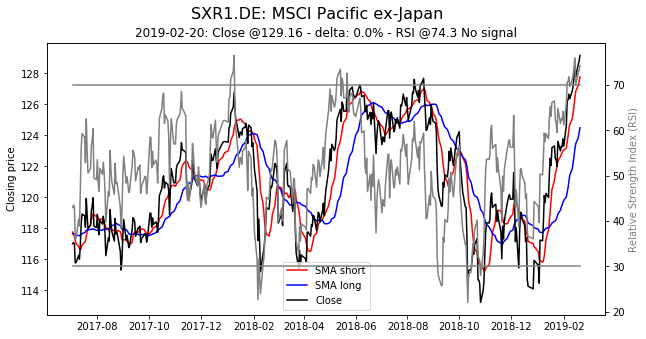

Done simmulating
*****************************
14:13:38.769834
14:23:38.870221


In [ ]:

def runIt(symbols, loop, download):
    from IPython.display import clear_output
    executionTime = datetime.time(9, 30, 0, 0)
    print(str(datetime.datetime.time(datetime.datetime.now())))
    daysRun = []
    if loop:
        while True:
            import time
            if executionTime < datetime.datetime.time(datetime.datetime.now()) and datetime.date.today().strftime("%Y-%m-%d") not in daysRun:
                clear_output()
                daysRun.append(datetime.date.today().strftime("%Y-%m-%d"))
                removePics()
                signals, result = runSmaAnalysis(True, True, symbols, download)
                if len(signals) == 0:
                    mailBody = 'No signals today'
                else:
                    mailBody = str(signals)
                sendMail('pedersbak@gmail.com','pedersbak@gmail.com', mailBody,'Signals for today',['output.pdf'])
            print(str(datetime.datetime.time(datetime.datetime.now())))
            time.sleep(600)
    else:
        removePics()
        signals, result = runSmaAnalysis(True, True, symbols, download)
        if len(signals) == 0:
            mailBody = 'No signals today'
        else:
            mailBody = str(signals)
        sendMail('pedersbak@gmail.com','pedersbak@gmail.com', mailBody,'Signals for today',['output.pdf'])


symbolsUSA = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','XOM','GS','HD','IBM','INTC',\
                  'JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA','GOOGL']

symbolsDK = ['MAERSK-A.CPH','MAERSK-B.CPH','BAVA.CPH','CARL-B.CPH','CHR.CPH','COLO-B.CPH'\
               ,'DANSKE.CPH','DSV.CPH','FLS.CPH','GEN.CPH','GN.CPH','ISS.CPH','JYSK.CPH'\
               ,'NOVO-B.CPH','NZYM-B.CPH','PNDORA.CPH','RBREW.CPH','SIM.CPH','TRYG.CPH','VWS.CPH','WDH.CPH'\
               ,'ORSTED.CPH','ALK-B.CPH','ALMB.CPH','DFDS.CPH','CARL-A.CPH','G4S.CPH','JDAN.CPH','TRYG.CPH','TOP.CPH'\
               ,'SYDB.CPH','STG.CPH','SCHO.CPH','ROCK-B.CPH','ROCK-A.CPH','RILBA.CPH','OSSR.CPH','NKT.CPH'\
               ,'LUN.CPH','KBHL.CPH','JDAN.CPH','FLS.CPH','DSV.CPH']
symbols={'SXRT.DE':'Euro STOXX 50',
         'IQQ9.DE':'FTSE BRIC 50',
         'IQQC.DE':'FTSE China 50',
         'EUNN.DE':'MSCI Japan',
         'SXR1.DE':'MSCI Pacific ex-Japan',
         'EUNL.DE':'MSCI World',
         'SXR8.DE':'S&P 500',
         'SXRU.DE':'Dow Jones Industrial',
         'IUSR.DE':'EURO STOXX 50 ex-Finanance',
         'SXRW.DE':'FTSE 100 UK',
         'SXRY.DE':'FTSE MIB Index / Italy',
         'IBC6.DE':'MSCI Australia UCITS',
         'CEBL.DE':'MSCI Emerging Markets Asia',
         'IUSC.DE':'MSCI Emerging Markets Latin America',
         'XDDX.DE':'DAX Income'}
loop=True
download=True
runIt(symbols, loop, download)

In [ ]:
#daysRun

In [ ]:
symbolsUSA = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','XOM','GS','HD','IBM','INTC',\
                  'JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA','GOOGL']

symbolsDK = ['MAERSK-A.CPH','MAERSK-B.CPH','BAVA.CPH','CARL-B.CPH','CHR.CPH','COLO-B.CPH'\
               ,'DANSKE.CPH','DSV.CPH','FLS.CPH','GEN.CPH','GN.CPH','ISS.CPH','JYSK.CPH'\
               ,'NOVO-B.CPH','NZYM-B.CPH','PNDORA.CPH','RBREW.CPH','SIM.CPH','TRYG.CPH','VWS.CPH','WDH.CPH'\
               ,'ORSTED.CPH','ALK-B.CPH','ALMB.CPH','DFDS.CPH','CARL-A.CPH','G4S.CPH','JDAN.CPH','TRYG.CPH','TOP.CPH'\
               ,'SYDB.CPH','STG.CPH','SCHO.CPH','ROCK-B.CPH','ROCK-A.CPH','RILBA.CPH','OSSR.CPH','NKT.CPH'\
               ,'LUN.CPH','KBHL.CPH','JDAN.CPH','FLS.CPH','DSV.CPH']
symbolsDE = ['EXXY.DE']

symbols=['NKE','GOOGL','AAPL','WMT']+sorted(set(symbolsDK))+sorted(set(symbolsDE))
#symbols = ['DANSKE.CPH']
len(symbols)